In [ ]:
from tqdm.notebook import tqdm
import tensorflow
tensorflow.__version__

'2.3.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_path = '/content/drive/My Drive/aiml/'

In [ ]:
data_path=project_path+'Aligned Face Dataset from Pinterest.zip'
weights_path=project_path+'vgg_face_weights.h5'

In [ ]:
from zipfile import ZipFile
with ZipFile(data_path,'r')as zip:
    zip.extractall()

In [ ]:
import numpy as np
import os
import random
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.gridspec as gridspec
random_state=1
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

In [ ]:
import cv2
def load_image(path):
    img = cv2.imread(path,1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [ ]:
model = vgg_face()
model.load_weights(weights_path)

In [ ]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [ ]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


In [ ]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

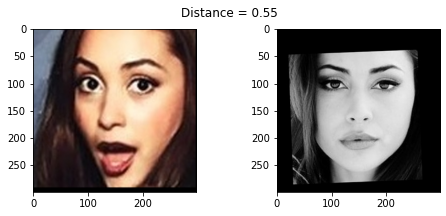

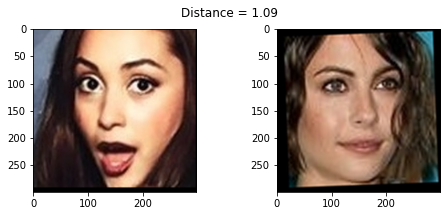

In [ ]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

In [ ]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

#### Add your code here ####

targets = np.array([m.name for m in metadata])
#train labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

#### Add your code here ####

In [ ]:
from sklearn.preprocessing import LabelEncoder

en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

In [ ]:
# Standarize features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [ ]:
from sklearn.decomposition import PCA

cov_matrix = np.cov(X_train_sc.T)

eig_vals, eig_vecs = np.linalg.eig(cov_matrix)


tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.5808296   18.94872248  22.92388108 ...  99.99999983  99.99999999
 100.        ]


In [ ]:
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

Index of element just greater than 95: 346


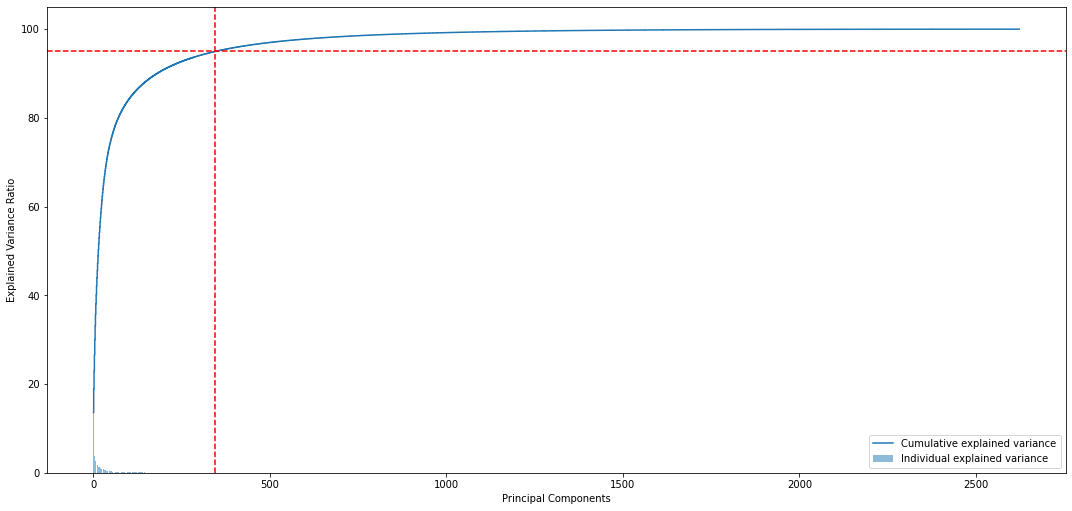

In [ ]:
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [ ]:
pca = PCA(n_components = index, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 346)

(1197, 346)

In [ ]:
from sklearn.svm import SVC

svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.995


In [ ]:
# Predict
y_pred = svc_pca.predict(X_test_pca)



In [ ]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       0.83      1.00      0.91        10
            Alvaro Morte       1.00      1.00      1.00        13
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         8
          Amaury Nolasco       1.00      1.00      1.00         9
        Amber Heard Face       1.00      1.00      1.00         7
               Anna Gunn       1.00      1.00      1.00        14
           Anne Hathaway       1.00      1.00      1.00        14
     Barbara Palvin Face       1.00      1.00      1.00         9
      Bellamy Blake Face       1.00      0.92      0.96        13
    Benedict Cumberbatch       1.00      1.00      1.00        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       1.00      1.00      

In [ ]:
def sample_img_plot(sample_idx):
  # Load image for sample_idx from test data
  sample_img = load_image(metadata[test_idx][sample_idx].image_path())
  # Get actual name
  actual_name = metadata[test_idx][sample_idx].name.split('_')[-1].title().strip()
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

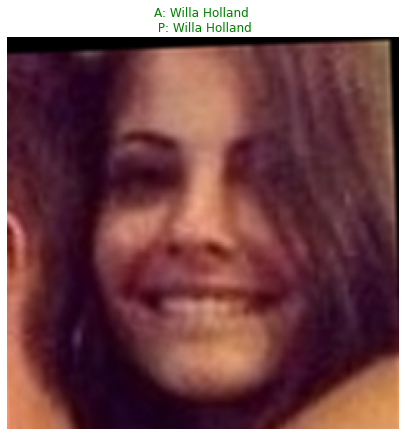

In [ ]:
sample_img, actual_name, pred_name = sample_img_plot(10)
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

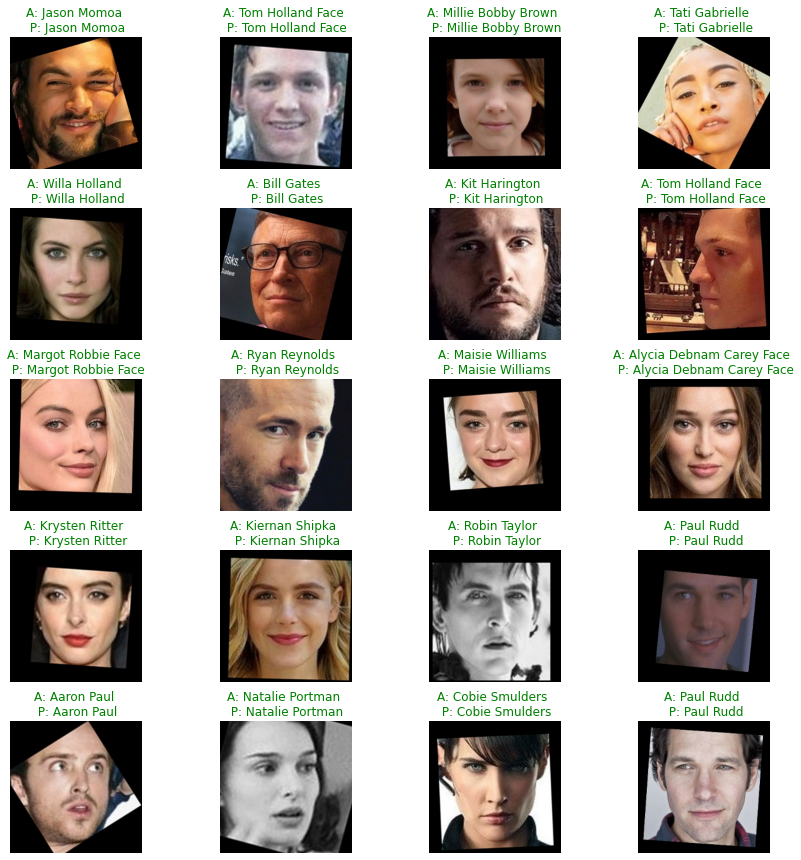

In [ ]:
plt.figure(figsize = (15, 15))
gs1 = gridspec.GridSpec(5, 4)
gs1.update(wspace = 0, hspace = 0.3) 

for i in range(20):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
    sample_img, actual_name, pred_name = sample_img_plot(random.randint(1, 1197))
  
    plt.axis('off')
    plt.imshow(sample_img)
  
    plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()